In [9]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [11]:
class Configuration:
    """Configuration (lattice) of the problem"""
    
    def __init__(self, population, N, M, beta, T_inf, Ts, Sage, P_initial, FindContactMatrix = False, MCS = 0): 
        """Constructor"""
        self.M = M # the linear size of the lattice
        self.population = population # the vector [1*4] which contains population percentages for each group (then put here the absalute value of number of people in each group)
        self.N = N # the total population
        self.beta = beta # age dependent inverse mobility vector
        self.T_inf = T_inf # the infective period
        self.Ts = Ts # the stop time (after Ts the symptomatic phase begins)
        self.Sage = Sage # the age-class susceptibility (probability to get infected when contacted with an infected individual)
        self.P_initial = P_initial # the vector [1*4] which contains the percentages of infected people in each group
        self.infected = np.zeros(4) # the number of infected people in each group
        self.ContactMatrix = np.zeros((N, 100)) # matrix with i row corresponding to i person's contacts. 1st column corresponds to the first free column index
        self.AverageContactMatrix = np.zeros((4,4)) # AverageContactMatrix[i, j]: the average number of contacts that a single individual of age-group i has with individuals of age-group j
        self.FindContactMatrix = FindContactMatrix # if true than code is a bit different
        self.MCS = MCS # how many MCS should pass to start fill the contact matrix
        self.MCScounter = 0 # how many MCS has been done
        
        # configuration - 2D matrix. 
        # 6 dimensions correspond to the 6D lattice
        # 1 dimension contains information about the age group, if the person infected or not, if the person has antibodies or not, as well as time counter and an index of an individual:
        # 1st layer M[0,:,:] corresponds to population distribution: 0 - the site is free, 1-4 the site is occupied by a person from the corresponding age group
        # 2nd layer M[1,:,:] corresponds to the "Infected" property of an individual. If the site is occupied then it is 1 or 0, otherwise np.nan
        # 3d layer M[2,:,:], likewise, corresponds to the "Antibodies" property of an individual.
        # 4d layer M[3,:,:], the time counter in MCS (Monte Carlo Steps) that is decremented after each MCS. When it is zero an infected person recovers. If a person is healthy then it is np.nan
        # 5d layer M[4,:,:], If a person is healthy then this is np.nan. Otherwise it is the time which is required for person to recover.
        # 6d layer M[5,:,:, If a person is healthy then this is np.nan. Otherwise it is the time after which symptomatic phase begins.
        # 7d layer M[6,:,:], The index of an individual. If there is no person at this site then it is 0
        self.config = np.zeros((7, M, M)) 
        
        # Put in the "population" vector the number of people in each age group
        self.population[0] = round(self.population[0] * N/100)
        self.population[1] = round(self.population[1] * N/100)
        self.population[2] = round(self.population[2] * N/100)
        self.population[3] = N - (self.population[0] + self.population[1] + self.population[2]) # to make sum equal to N
        
        # The auxiliary matrix to make the 1st layer M[0,:,:,:,:,:] of the configuration matrix. Population is randomly distributed
        A = np.hstack([1*np.ones(self.population[0]), 2*np.ones(self.population[1]), 3*np.ones(self.population[2]), 4*np.ones(self.population[3]), np.zeros(self.M**2 - N)]) 
        
        # The auxiliary matrix to make the 2st layer M[1,:,:,:,:,:] of the configuration matrix.
        B = np.hstack([np.random.choice([0, 1], size = (self.population[0]), p = [1 - P_initial[0]/100, P_initial[0]/100]), np.random.choice([0, 1], size = (self.population[1]), p = [1 - P_initial[1]/100, P_initial[1]/100]), np.random.choice([0, 1], size = (self.population[2]), p = [1 - P_initial[2]/100, P_initial[2]/100]), np.random.choice([0, 1], size = (self.population[3]), p = [1 - P_initial[3]/100, P_initial[3]/100]), np.nan * np.ones(self.M**2 - N)])
        
        # The auxiliary matrix to make the 3st layer M[2,:,:,:,:,:] of the configuration matrix. No one initially has antibodies
        C = np.hstack([np.random.choice([0, 1], size = (self.N), p = [1, 0]), np.nan * np.ones(self.M**2 - N)]) 
        # those who are infective do not have antibodies yet (this line is necessary if we set some people, say 1% to have antibodies)
        C[B == 1] = 0
        
        # The auxiliary matrix to make the 4st layer M[3,:,:,:,:,:] of the configuration matrix.
        # It contains the time counter (with exponential distribution with a truncation of the distribution at 5*T_inf) wich decreases by 1 each MCS. At time t = 0 the person recovers. If the person is healthy then the value is np.nan
        D = np.hstack([np.random.exponential(size = N, scale = self.T_inf), np.nan*np.ones(self.M**2-N)])
        D[D > 5*self.T_inf] = 5*self.T_inf
        D[B == 0] = np.nan
        
        # The auxiliary matrix to make the 5st layer M[4,:,:,:,:,:] of the configuration matrix.
        # It does not depend on time (in contrast with M[3,:,:,:,:,:])
        E = D
        
        # The auxiliary matrix to make the 6st layer M[5,:,:,:,:,:] of the configuration matrix.
        # It contains the time after which symptomatic phase begins. (with exponential distribution with a truncation of the distribution at 5*Ts)
        F = np.hstack([np.random.exponential(size = N, scale = self.Ts), np.nan*np.ones(self.M**2-N)])
        F[F > 5*self.Ts] = 5*self.Ts
        F[B == 0] = np.nan
        
        # The auxiliary matrix to make the 7st layer M[6,:,:,:,:,:] of the configuration matrix. 
        # It contains an index of each person, used for finding the contact matrix
        G = np.hstack([np.arange(1, self.N + 1), np.zeros(self.M**2 - N)])
        
        
        # We vstack the auxiliary matrices, shuffle to make random and reshape into 7D matrix
        H = np.vstack([A, B, C, D, E, F, G])
        # we transpose because the shuffle function shuffles only along the 1st axis  
        H = np.transpose(H)
        np.random.shuffle(H)
        H = np.transpose(H)
        A, B, C, D, E, F, G = H[0], H[1], H[2], H[3], H[4], H[5], H[6]
        self.config = np.stack([A.reshape((M,M)), B.reshape((M,M)), C.reshape((M,M)), D.reshape((M,M)), E.reshape((M,M)), F.reshape((M,M)), G.reshape((M,M))])
        self._calculate_infected()
        
    def _calculate_infected(self):
        """Calculate the number of infected people in each age group"""
        for i in range(4):
            self.infected[i] = np.sum(self.config[1][self.config[0] == i + 1])
        return self.infected
        
    def _calculate_ContactMatrix(self):
        """Calculate the contact matrix"""
        for i in range(self.M):
            for j in range(self.M):
                a = (int)(self.config[6, i, j]) # 6 layer with index of each person
                if a == 0:
                    continue
                for i1, j1 in [(1,0), (-1,0), (0, 1), (0, -1)]:
                    b = self.config[6, (i + i1)%self.M, (j + j1)%self.M] # neighbour
                    if b != 0 and b not in self.ContactMatrix[a - 1, 1:]:
                        self.ContactMatrix[a - 1, (int)(self.ContactMatrix[a - 1, 0]) + 1] = b
                        self.ContactMatrix[a - 1, 0] += 1
             
            
    def _calculate_AverageContactMatrix(self):
        for i in range(self.population[0]):
            for j in range(1, (int)(self.ContactMatrix[i, 0]) + 1):
                if self.ContactMatrix[i, j] <= self.population[0]:
                    self.AverageContactMatrix[0, 0] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1]:
                    self.AverageContactMatrix[0, 1] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1] + self.population[2]:
                    self.AverageContactMatrix[0, 2] += 1
                elif self.ContactMatrix[i, j] <= self.N:
                    self.AverageContactMatrix[0, 3] += 1
        for i in range(self.population[0], self.population[0] + self.population[1]):
            for j in range(1, (int)(self.ContactMatrix[i, 0]) + 1):
                if self.ContactMatrix[i, j] <= self.population[0]:
                    self.AverageContactMatrix[1, 0] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1]:
                    self.AverageContactMatrix[1, 1] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1] + self.population[2]:
                    self.AverageContactMatrix[1, 2] += 1
                elif self.ContactMatrix[i, j] <= self.N:
                    self.AverageContactMatrix[1, 3] += 1
        for i in range(self.population[0] + self.population[1], self.population[0] + self.population[1] + self.population[2]):
            for j in range(1, (int)(self.ContactMatrix[i, 0]) + 1):
                if self.ContactMatrix[i, j] <= self.population[0]:
                    self.AverageContactMatrix[2, 0] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1]:
                    self.AverageContactMatrix[2, 1] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1] + self.population[2]:
                    self.AverageContactMatrix[2, 2] += 1
                elif self.ContactMatrix[i, j] <= self.N:
                    self.AverageContactMatrix[2, 3] += 1
        for i in range(self.population[0] + self.population[1] + self.population[2], self.N):
            for j in range(1, (int)(self.ContactMatrix[i, 0]) + 1):
                if self.ContactMatrix[i, j] <= self.population[0]:
                    self.AverageContactMatrix[3, 0] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1]:
                    self.AverageContactMatrix[3, 1] += 1
                elif self.ContactMatrix[i, j] <= self.population[0] + self.population[1] + self.population[2]:
                    self.AverageContactMatrix[3, 2] += 1
                elif self.ContactMatrix[i, j] <= self.N:
                    self.AverageContactMatrix[3, 3] += 1
        self.AverageContactMatrix[0,:] /= self.population[0]
        self.AverageContactMatrix[1,:] /= self.population[1]
        self.AverageContactMatrix[2,:] /= self.population[2]
        self.AverageContactMatrix[3,:] /= self.population[3]
        
        
    def _near_neighbors(self, age_group, i, j):
        return int((age_group == self.config[0, i, (j + 1)%self.M]) + \
        (age_group == self.config[0, i, (j - 1)%self.M]) + \
        (age_group == self.config[0, (i + 1)%self.M, j]) + \
        (age_group == self.config[0, (i - 1)%self.M, j]))

<br>

In [12]:
def metropolis_move(obj):
    """One elementary step, Metropolis move. It modifies the configuration with the Metropolis algorithm,
    taking into account the adaptive mobility rules"""
    
    M = obj.M
    
    # randomly choose an individual site 1
    i, j = np.random.randint(M, size = (2)) 

    # we exit the function if there is NO person at the randomly selected site
    age_group = obj.config[0, i, j]
    if age_group == 0:
        return None 
    
    beta = obj.beta[(int)(age_group - 1)]
        
    # The first adaptive mobility rule: the infected person stops moving if he goes through symptomatic phase (T < Ts)
    if obj.config[1,i,j] == 1 and obj.config[3,i,j] < obj.config[4,i,j] - obj.config[5,i,j]:
        return None
    
    
    # randomly choose nearest neighbor destination (site 2)
    i1 = np.random.choice([1, 2]) # randomly choose direction / dimension of movement
    j1 = np.random.choice([1, -1]) # forward or backward
    if i1 == 1:
        i1, j1 = j1, 0
    if i1 == 2:
        i1, j1 = 0, j1
    
    
    # Exit the function if there IS person at the randomly selected destination site 2
    if obj.config[0, (i + i1)%M, (j + j1)%M] != 0:
        return None 
    
    # The second adaptive mobility rule: susceptible individuals tend to avoid contacts with the infected ones 
    # in their symptomatic phase. If any neighbour at the destination site is going throught the symptomatic phase then we don't do the move. 
    if obj.config[1, i, j] == 0 and \
    ((obj.config[3][(i+i1+1)%M, (j+j1)%M] < obj.config[4][(i+i1+1)%M, (j+j1)%M] - obj.config[5][(i+i1+1)%M, (j+j1)%M]) or \
     (obj.config[3][(i+i1-1)%M, (j+j1)%M] < obj.config[4][(i+i1-1)%M, (j+j1)%M] - obj.config[5][(i+i1-1)%M, (j+j1)%M]) or \
     (obj.config[3][(i+i1)%M, (j+j1+1)%M] < obj.config[4][(i+i1)%M, (j+j1+1)%M] - obj.config[5][(i+i1)%M, (j+j1+1)%M]) or \
     (obj.config[3][(i+i1)%M, (j+j1-1)%M] < obj.config[4][(i+i1)%M, (j+j1-1)%M] - obj.config[5][(i+i1)%M, (j+j1-1)%M])) :
        return None 
    
    
    # compute the difference of nearest neighbor effective number for the sites 1 and 2
    delta_N = obj._near_neighbors(age_group, (i + i1)%M, (j + j1)%M) - 1 - obj._near_neighbors(age_group, i, j)
    
    
    # accept modification with Metropolis probability
    # if not accepted: leave configuration unchanged
    if np.random.random() < min(1, np.exp(beta*delta_N)):
        obj.config[:, (i + i1)%M, (j + j1)%M] = obj.config[:, i, j]
        obj.config[:, i, j] = [0, np.nan, np.nan, np.nan, np.nan, np.nan, 0]
        
        

In [13]:
def monte_carlo_step(obj):
    """This is a MCS (Monte Carlo Step): we make M**6 steps so that on average every individual 
    attempts to move one time. Then we update the epidemiological data of each individual according the SRI model"""
    
    M = obj.M
    obj.MCScounter += 1
    if obj.FindContactMatrix == True and obj.MCScounter > obj.MCS:
        obj._calculate_ContactMatrix()
    
    # At the beginning of each timestep, we consider the infected people recover. 
    # We go through the lattice and recover certain people whose infection time has come.
    obj.config[3][obj.config[3] > 0] -= 1 # if time is more than zero then subtract 1
    obj.config[4][obj.config[3] <= 0] = np.nan # if person recovered than T_ind and Ts = np.nan
    obj.config[5][obj.config[3] <= 0] = np.nan 
    
    obj.config[1][obj.config[3] <= 0] = 0 # if time for individual is zero, then he recovers
    obj.config[2][obj.config[3] <= 0] = 1 # and acquires antibodies
    obj.config[3][obj.config[3] <= 0] = np.nan
    
    for i in range(M**2):
        metropolis_move(obj)

        
    # if we look for the contact matrix then everyone is healthy and no need to renew the matrices of infection/antibodies etc.
    if obj.FindContactMatrix == False:
        for i in range(M):
            for j in range(M):
                age_group = obj.config[0, i, j]
                if age_group == 0:
                    continue

                # if the selected person does not have antibodies and not infected and some of the new neighbors are infected 
                # then the person gets infected with probability Sage[age group]
                # Mb better to create new matrix (?)
                if np.random.random() < obj.Sage[int(age_group - 1)] and obj.config[1, i, j] == 0 and \
                obj.config[2, i, j] == 0 and \
                (obj.config[1, (i + 1)%M, j] == 1 or obj.config[1, i - 1, j] == 1 or \
                obj.config[1, i, (j + 1)%M] == 1 or obj.config[1, i, j - 1] == 1):
                    obj.config[1, i, j] = 1
                    a = np.random.exponential(scale = obj.T_inf)
                    obj.config[3, i, j] = min(a, 5 * obj.T_inf)
                    obj.config[4, i, j] = obj.config[3, i, j]
                    a = np.random.exponential(scale = obj.Ts)
                    obj.config[5, i, j] = min(a, 5 * obj.Ts)

<br>

### In this section we try to find such value of $\beta$ that the average number of contacts for each age group corresponds to the Polymod data
<br>
Preliminary we manually found that if $\beta$ = [3.4, 0, 0.6, 3.7], then the average number of contacts for each age group is close to the Polymod data. Then we 

In [14]:
np.random.seed(0)
# setting the parameters

# the number of MCS correspondinig to one day (as in the paper):
day = 120
# to find beta we consider the contact dynamics when everyone is healthy, the initial condition infection vector is equal to 0
P_initial = [0, 0, 0, 0]
# population age distribution of Italy 
popul = [4.8, 9.3, 65.9, 20]
# population of a city simulated
N = 9331
# lenght of the lattice side
M = 216
# infective time (in MCS)
T_inf = 5*day
# stop time (in MCS)
Ts = 1*day
# susceptibility vector (is irrelevant for this simulation, we set it to 0)
Sage = [0, 0, 0, 0]
# the number of steps that we make to ensure the system reaches stationary state
MCSN = 1*day
FindContactMatrix = True

# Polymod data, average number of contacts for each age group
CPolymod = [15, 23.5, 19.5, 12.5]

In [17]:
# THIS SIMULATION REQUIRES >8 hours. YOU CAN SKIP IT AND GO TO THE NEXT SECTION WHERE WE USE ALREADY FOUND BETA!
# we set beta around [3.4, 0, 0.6, 3.7]
beta1 = np.arange(3.2, 3.7, 0.1)
beta2 = np.arange(0, 0.5, 0.1)
beta3 = np.arange(0.4, 0.9, 0.1)
beta4 = np.arange(3.4, 3.9, 0.1)

# Average number of contacts
Cj = np.zeros((beta1.shape[0], beta2.shape[0], beta3.shape[0], beta4.shape[0]), 4)

for i in range(beta1.shape[0]):
    for j in range(beta2.shape[0]):
        for m in range(beta3.shape[0]):
            for n in range(beta4.shape[0]):
                c = Configuration([4.8, 9.3, 65.9, 20], N, M, [beta1[i], beta2[j], beta3[m], beta4[n]], T_inf, Ts, Sage, P_initial, FindContactMatrix, MCSN)
                for i in range(day + MCSN):
                    monte_carlo_step(c)
                c._calculate_AverageContactMatrix()
                Cj[i,j,m,n,:] = c.AverageContactMatrix.sum(axis = 1)

In [15]:
# We find that beta = [3.5, 0, 0.5, 3.5]
# Let's look how well it corresponds to the Polymod data:
beta = [3.5, 0, 0.5, 3.5]
c = Configuration([4.8, 9.3, 65.9, 20], N, M, beta, T_inf, Ts, Sage, P_initial, FindContactMatrix, MCSN)
for i in range(day + MCSN):
    monte_carlo_step(c)
    
c._calculate_AverageContactMatrix()
# print('Contact Matrix:\n', c.AverageContactMatrix,'\n')
print('\nAverage number of contacts for each age group with used beta:\n', c.AverageContactMatrix.sum(axis = 1))
print('\nThe Polymod data:\n', CPolymod)


Average number of contacts for each age group with used beta:
 [15.76339286 20.30414747 19.13368027 12.80010718]

The Polymod data:
 [15, 23.5, 19.5, 12.5]


<br>

### Now, when we've found $\beta$, let's simulate the disease curves

In [16]:
np.random.seed(0)
# setting the parameters

# the number of MCS correspondinig to one day (as in the paper):
day = 120
# the initial condition infection vector (percantage of infected people in each age group)
P_initial = [0.3, 0.7, 0.1, 0.05]
# population age distribution of Italy 
population = [4.8, 9.3, 65.9, 20]
# population of a city simulated
N = 9331
# lenght of the lattice side
M = 216
# infective time (in MCS)
T_inf = 5*day
# stop time (in MCS)
Ts = 1*day
# susceptibility vector (here we set it as in the paper)
Sage = [0.07, 0.12, 0.019, 0.004]
# the number of steps that we make to ensure the system reaches stationary state
MCSN = 1*day
beta = [3.5, 0, 0.5, 3.5]
FindContactMatrix = False

calculating  1  simulation. Day  1


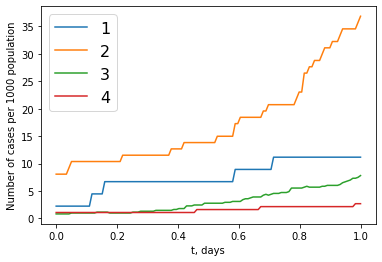

In [17]:
# the number of realization over which we average our data
Naverage = 1 # WE WANTED TO SET IT TO 5
# the number of days simulated
Ndays = 1 # 3 WEEKS?
infected = np.zeros((Naverage, Ndays*day, 4))

for i in range(Naverage):
    c = Configuration([4.8, 9.3, 65.9, 20], N, M, beta, T_inf, Ts, Sage, P_initial, FindContactMatrix, MCSN)
    for j in range(Ndays*day):
        if j%day == 0:
            print("calculating ", i + 1, " simulation. Day ", j + 1,)
        monte_carlo_step(c)
        infected[i, j, :]= c._calculate_infected()
    
infected_average = np.average(infected, axis = 0)
t = np.linspace(0, Ndays, Ndays*day)

plt.plot(t, infected_average[:, 0] * 1000 / c.population[0], label = "1")
plt.plot(t, infected_average[:, 1] * 1000 / c.population[1], label = "2")
plt.plot(t, infected_average[:, 2] * 1000 / c.population[2], label = "3")
plt.plot(t, infected_average[:, 3] * 1000 / c.population[3], label = "4")
plt.xlabel("t, days")
plt.ylabel("Number of cases per 1000 population")
plt.legend(fontsize = 16)

plt.show()

# os.system('say "finished"')